# Árboles de decisión

### Obtención de los datos de entrada

Predicción del “Billboard 100”: ¿Qué artista llegará al número uno del ranking?
A partir de atributos de cantantes y de un histórico de canciones que alcanzaron entrar al Billboard 100 (U.S.) en 2013 y 2014 crearemos un árbol que nos permita intentar predecir si un nuevo cantante podrá llegar a número uno.

Utilicé un código python para hacer scraping de una web pública “Ultimate Music Database” con información histórica del Billboard que obtuve de este artículo: “Analyzing billboard 100″. Luego completé atributos utilizando la API de Deezer (duración de las canciones), la API de Gracenote (género y ritmo de las canciones). Finalmente agregué a mano varias fechas de nacimiento de artistas utilizando la Wikipedia que no había conseguido con la Ultimate Music Database. Algunos artistas quedaron sin completar su fecha de nacimiento y con valor 0. Veremos como superar este obstáculo tratando los datos.

In [43]:
# Imports needed for the script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
artists_billboard = pd.read_csv(r"C:/Users/BAYASD/Downloads/artists_billboard_fix3.csv")



In [44]:
artists_billboard.shape

(635, 11)

Esto nos devuelve (635,11) es decir que tenemos 11 columnas (features) y 635 filas de datos.

In [45]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628.0,191.0,0.0,1975.0
1,1,Bang Bang,JESSIE J ARIANA GRANDE & NICKI MINAJ,Energizing,Medium Tempo,Pop,Female,20140816.0,368.0,0.0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118.0,223.0,1.0,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104.0,206.0,0.0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301.0,232.0,0.0,0.0


Vemos que tenemos: Titulo de la canción, artista, “mood” ó estado de ánimo de esa canción, tempo, género, Tipo de artista, fecha en que apareció en el billboard (por ejemplo 20140628 equivale al 28 de junio de 2014), la columna TOP será nuestra etiqueta, en la que aparece 1 si llegó al número uno de Billboard ó 0 si no lo alcanzó y el anio de Nacimiento del artista. Vemos que muchas de las columnas contienen información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que nos convendrá pasar a categórico más adelante.

Primero, agrupemos registros para ver cuántos alcanzaron el número uno y cuantos no:

In [46]:
artists_billboard.groupby('top').size()

top
0.0    481
1.0    139
dtype: int64

Es decir que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad DESBALANCEADA de etiquetas con 1 y 0. Lo tendremos en cuenta al momento de crear el árbol.

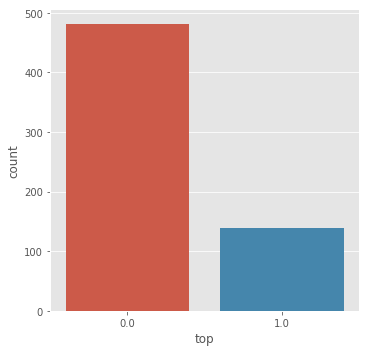

In [48]:
sb.catplot('top',data=artists_billboard,kind="count")

Veamos cuántos registros hay de tipo de artista, “mood”, tempo y género de las canciones:

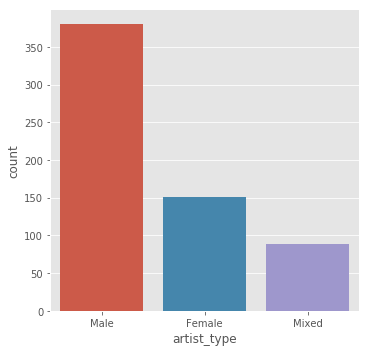

In [50]:
sb.catplot('artist_type',data=artists_billboard,kind="count")

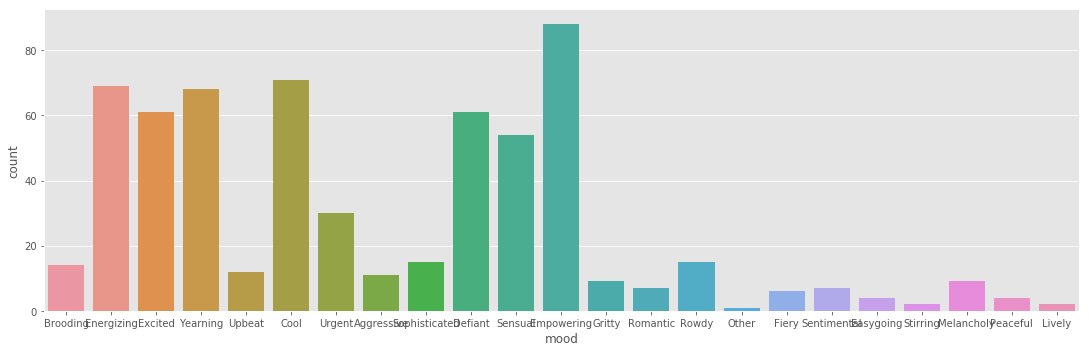

In [52]:
sb.catplot('mood',data=artists_billboard,kind="count", aspect=3)

Vemos que de 23 tipos de Mood, destacan 7 con picos altos. Además notamos que algunos estados de ánimo son similares

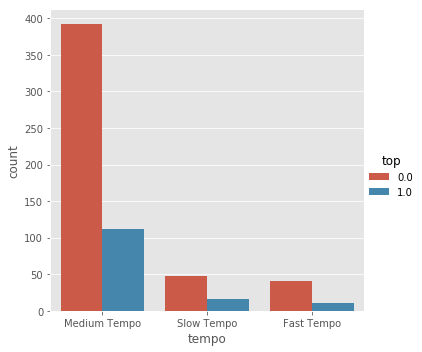

In [55]:
sb.catplot('tempo',data=artists_billboard,hue='top',kind="count")

En esta gráfica vemos que hay 3 tipos de Tempo: Medium, Slow y Fast. Evidentemente predominan los tiempos Medium y también es donde encontramos más canciones que hayan alcanzado el Top 1 (en azul)

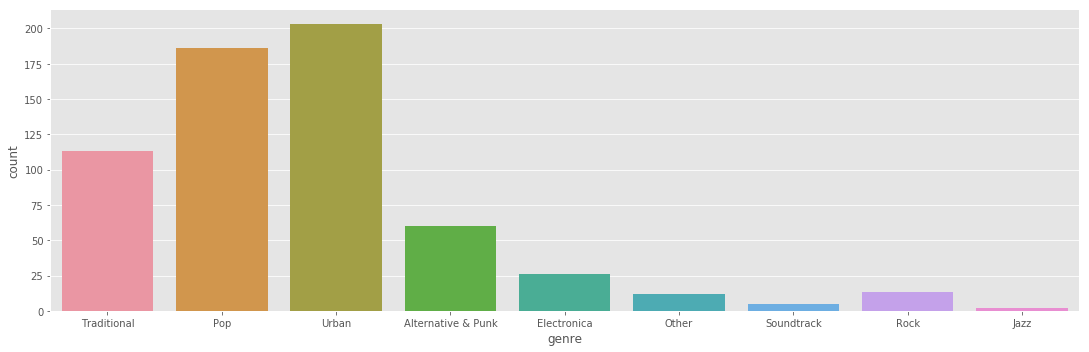

In [57]:
sb.catplot('genre',data=artists_billboard,kind="count", aspect=3)

Entre los géneros musicales destacan Urban y Pop, seguidos de Tradicional.

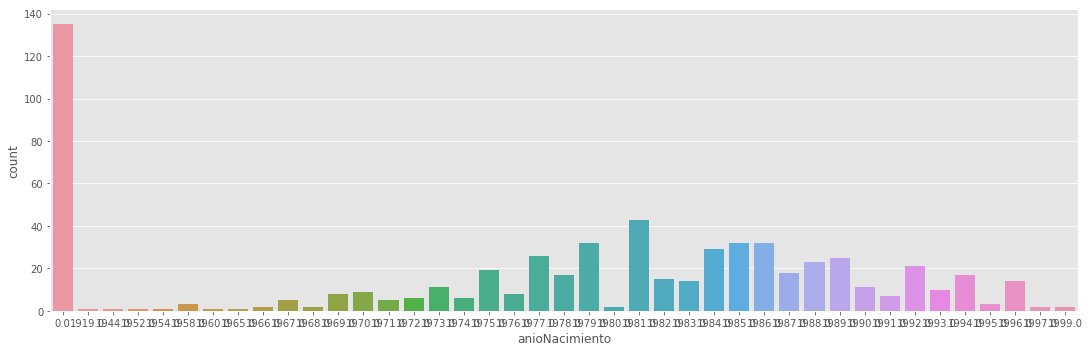

In [58]:
sb.catplot('anioNacimiento',data=artists_billboard,kind="count", aspect=3)

Aqui notamos algo raro: en el año “cero” tenemos cerca de 140 registros…
Como se ve en la gráfica tenemos cerca de 140 canciones de las cuales desconocemos el año de nacimiento del artista. El resto de años parecen concentrarse entre 1979 y 1994 (a ojo). Más adelante trataremos estos registros.

### Balanceo de Datos: Pocos artistas llegan al número uno

Como dijimos antes, no tenemos “equilibrio” en la cantidad de etiquetas top y “no-top” de las canciones. Esto se debe a que en el transcurso de un año, apenas unas 5 o 6 canciones logran el primer puesto y se mantienen durante varias semanas en ese puesto. Cuando inicialmente extraje las canciones, utilicé 2014 y 2015 y tenía apenas a 11 canciones en el top de Billboard y 494 que no llegaron.
Para intentar equilibrar los casos positivos agregué solamente los TOP de los años 2004 al 2013. Con eso conseguí los valores que tenemos en el archivo csv: son 494 “no-top” y 141 top. A pesar de esto sigue estando desbalanceado, y podríamos seguir agregando sólo canciones TOP de años previos, pero utilizaremos un parámetro del algoritmo de árbol de decisión para compensar esta diferencia.

Visualicemos los top y no top de acuerdo a sus fechas en los Charts:

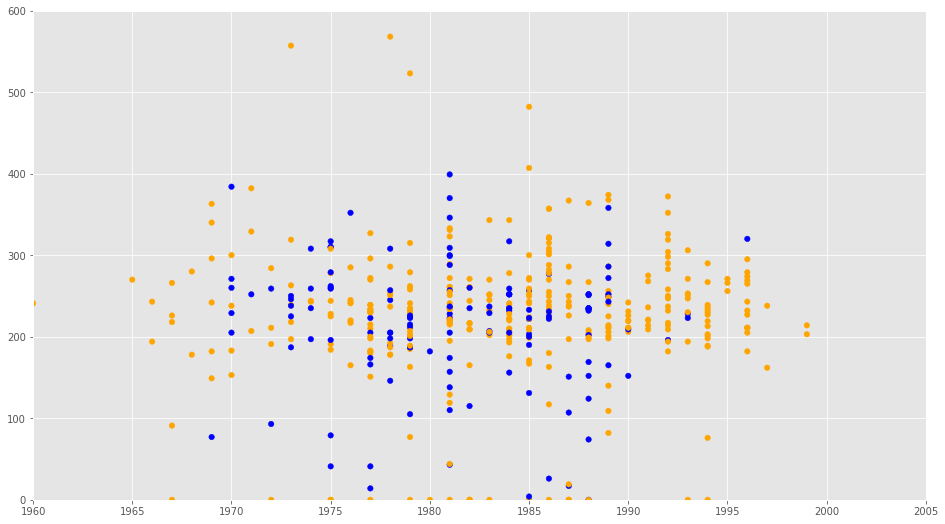

In [77]:
colores=['orange','blue']
tamanios=[60,40]

f1 = artists_billboard['anioNacimiento'].values
f2 = artists_billboard['durationSeg'].values

artists_billboard['top'].fillna(0, inplace=True)

asignar=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[int(row['top'])])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

No perece haber ningún patron a la vista, están bastante mezclados los top de los no-top.

veamos en que años tenemos Top

#### Preparamos los datos

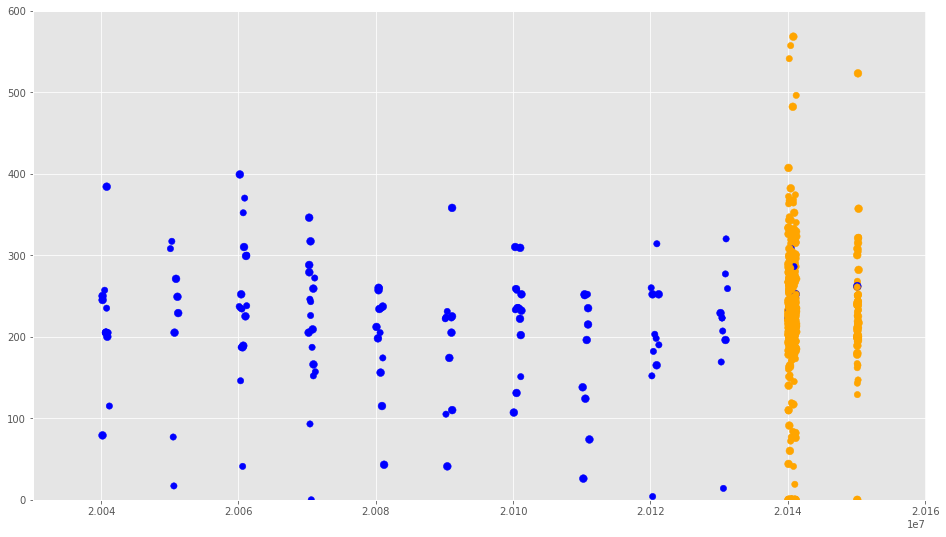

In [78]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
asignar2=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[int(row['top'])])
    asignar2.append(tamanios[int(row['top'])])

plt.scatter(f1, f2, c=asignar, s=tamanios)
plt.axis([20030101,20160101,0,600])
plt.show()

Esto es porque inicialmente tomé información de 2014 y 2015 y había casi 500 no-top contra sólo 11 registros top. Entonces tomé a los artistas que alcanzaron el top entre 2004 y 2013 para sumar casos positivos y equilibrar un poco nuestros datos de entrada. Así y todo, sigue estando desbalanceado.

#### Arreglar las Edades de Artistas

In [107]:
import math
def edad_fix(anio):
    if anio==0:
        return None
    if math.isnan(anio):
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

In [115]:
def calcula_edad(anio,cuando):
    if math.isnan(anio):
        return None
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    
    return int(momento) - anio

In [117]:
artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

In [118]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628.0,191.0,0.0,1975.0,39.0
1,1,Bang Bang,JESSIE J ARIANA GRANDE & NICKI MINAJ,Energizing,Medium Tempo,Pop,Female,20140816.0,368.0,0.0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118.0,223.0,1.0,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104.0,206.0,0.0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301.0,232.0,0.0,NaN,NaN


#### Calculamos promedio de edad y asignamos a los registros Nulos

In [119]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10103092783505
Desvió Std Edad: 8.431303523197418
Intervalo para asignar edad aleatoria: 21 a 38


#### Visualizamos las edades que agregamos

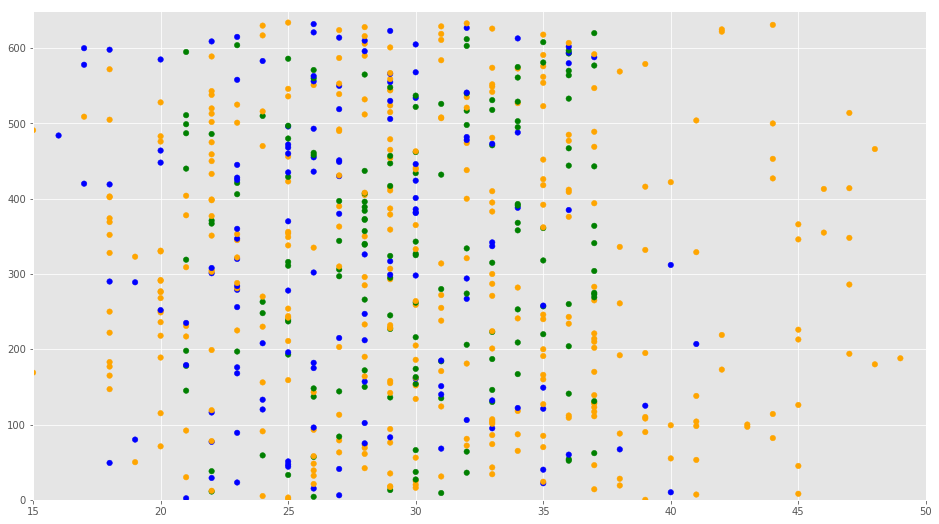

In [121]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[int(row['top'])])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

#### Mapeo de Atributos

Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión

In [122]:
separador = "### ### ###"
grouped11 = artists_billboard.groupby('mood').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)
print(separador)
print("Tempos de Canción: " + str(artists_billboard['tempo'].unique()))
print(separador)
print("Tipos de Artista: " + str(artists_billboard['artist_type'].unique()))
print(separador)
grouped11 = artists_billboard.groupby('genre').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)

mood
Empowering       88
Cool             71
Energizing       69
Yearning         68
Excited          61
Defiant          61
Sensual          54
Urgent           30
Sophisticated    15
Rowdy            15
Brooding         14
Upbeat           12
Aggressive       11
Gritty            9
Melancholy        9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64
### ### ###
Tempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo' nan]
### ### ###
Tipos de Artista: ['Male' 'Female' 'Mixed' nan]
### ### ###
genre
Urban                 203
Pop                   186
Traditional           113
Alternative & Punk     60
Electronica            26
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64


In [145]:
# Mood Mapping 
artists_billboard['mood'].fillna('Other', inplace=True)
artists_billboard['tempo'].fillna('', inplace=True)
artists_billboard['genre'].fillna('', inplace=True)
artists_billboard['artist_type'].fillna('', inplace=True)

artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping 
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0}).astype(int)
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

In [146]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

In [147]:
artists_encoded.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0.0,4,2,2,3,3.0,2.0
1,0.0,6,2,3,2,1.0,6.0
2,1.0,5,2,4,1,0.0,3.0
3,0.0,4,2,1,3,1.0,2.0
4,0.0,4,2,2,2,1.0,3.0


In [130]:
artists_encoded.describe()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,620.000000
mean,0.218898,4.239370,1.688189,2.669291,2.411024,2.050394,3.177419
std,0.413825,1.492154,0.652901,1.223167,0.815584,1.134759,1.775112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000
75%,0.000000,5.000000,2.000000,4.000000,3.000000,3.000000,4.000000
max,1.000000,6.000000,2.000000,4.000000,3.000000,4.000000,6.000000


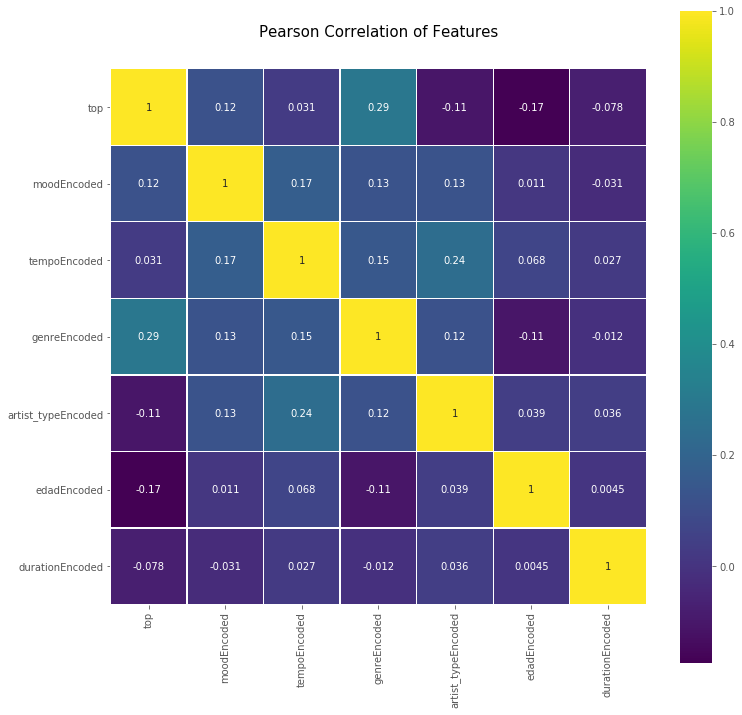

In [131]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(artists_encoded.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [132]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top            
                 mean count   sum
moodEncoded                      
0            0.000000    16   0.0
1            0.000000     8   0.0
2            0.278689    61  17.0
3            0.150000   100  15.0
4            0.137931   145  20.0
5            0.304054   148  45.0
6            0.267516   157  42.0

In [133]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top            
                        mean count   sum
artist_typeEncoded                      
0                   0.000000    15   0.0
1                   0.314607    89  28.0
2                   0.324503   151  49.0
3                   0.163158   380  62.0

In [134]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top            
                  mean count   sum
genreEncoded                      
0             0.058824    34   2.0
1             0.070707    99   7.0
2             0.008850   113   1.0
3             0.322581   186  60.0
4             0.339901   203  69.0

In [135]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top             
                  mean count    sum
tempoEncoded                       
0             0.164179    67   11.0
1             0.250000    64   16.0
2             0.222222   504  112.0

In [136]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top            
                     mean count   sum
durationEncoded                      
0.0              0.300000    70  21.0
1.0              0.344828    29  10.0
2.0              0.219048   105  23.0
3.0              0.208589   163  34.0
4.0              0.225225   111  25.0
5.0              0.148148    54   8.0
6.0              0.204545    88  18.0

In [137]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top            
                 mean count   sum
edadEncoded                      
0.0          0.246377    69  17.0
1.0          0.340426   141  48.0
2.0          0.238994   159  38.0
3.0          0.158371   221  35.0
4.0          0.022222    45   1.0

#### Buscamos nuestro Arbol de Decisión

In [149]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)
artists_encoded = pd.DataFrame(artists_encoded).fillna(0)#rellenar nan con 0

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['top'], axis=1), y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), y = f_valid["top"]) 
        # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.575000
        2          0.586037
        3          0.586086
        4          0.658408
        5          0.652158
        6          0.639410
        7          0.669221


#### Creamos el Arbol de Decisión

In [220]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values 

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
#check_call([r'D:\Users_info\BAYASD\Anaconda\pkgs\graphviz-2.38.0-4\Library\bin\dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])


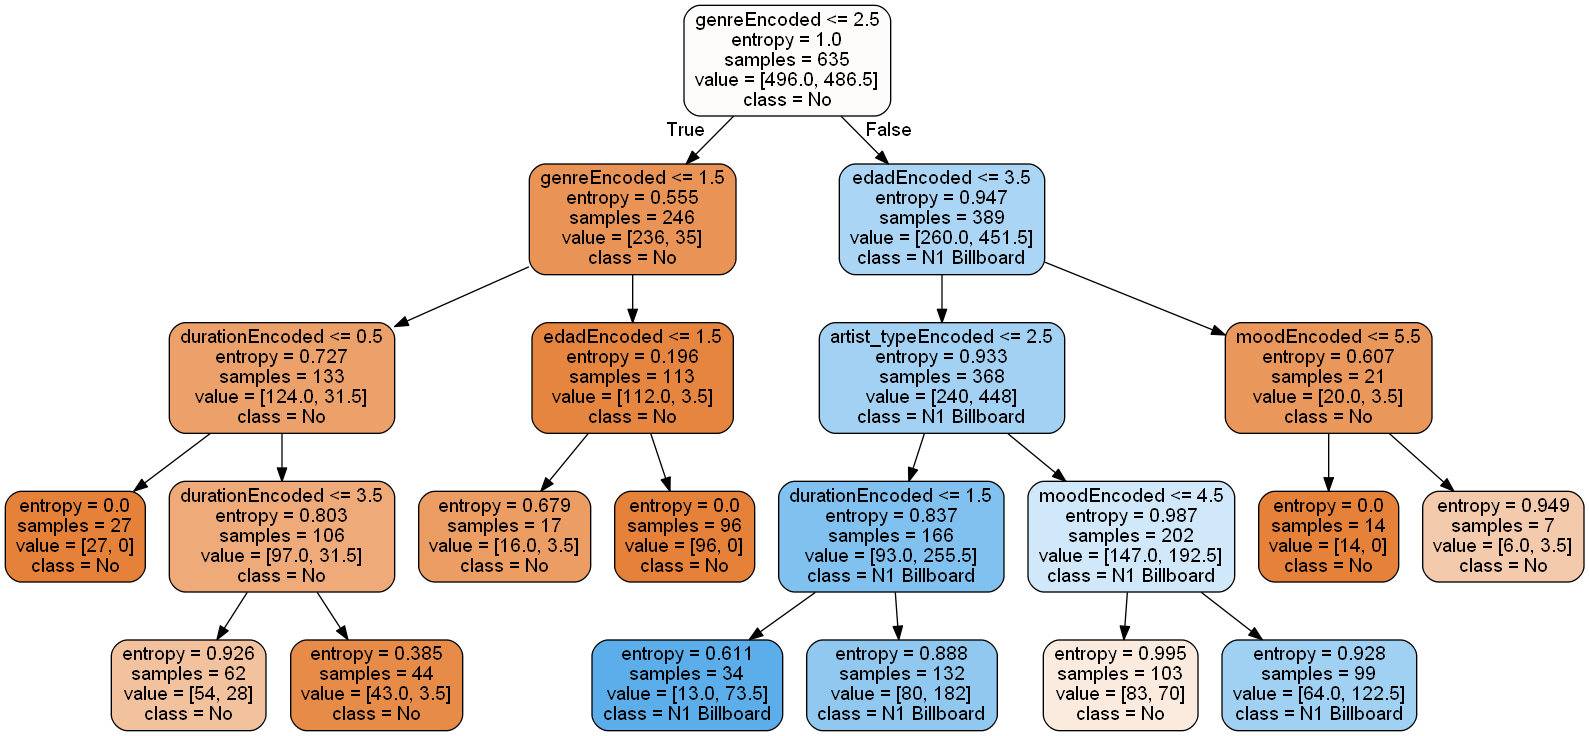

In [217]:
PImage(r"C:\Users\BAYASD\Downloads\tree1.png")

#### Precisión del árbol

In [235]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

70.39


### Predicción del árbol de decisión

In [233]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(int(y_pred)))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][int(y_pred[0])]* 100, 2))+"%")

Prediccion: 1
Probabilidad de Acierto: 69.47%


In [234]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(int(y_pred)))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][int(y_pred[0])]* 100, 2))+"%")

Prediccion: 0
Probabilidad de Acierto: 65.85%
